# Check reoncstruction of best models for each chromosome in detail

In [1]:
import os
import pandas as pd
import numpy as np
import pickle 
import torch
from scripts.visualisation import plot_cpg_reconstruction, plot_activations_latSpace, plot_all_cpgs_reconstruction
from scripts.train_RFregressor import RFregression
from data.prepareData import prepareDataLoader_fromPkl
import matplotlib.pyplot as plt
import seaborn as sns
import json

from tensorflow.python.summary.summary_iterator import summary_iterator

2023-01-30 22:42:42.089388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/easybuild/software/Python/3.9.5-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/OpenSSL/1.1/lib:/opt/ohpc/pub/easybuild/software/libffi/3.3-GCCcore-10.3.0/lib64:/opt/ohpc/pub/easybuild/software/libffi/3.3-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/GMP/6.2.1-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/XZ/5.2.5-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/SQLite/3.35.4-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/Tcl/8.6.11-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/libreadline/8.1-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/ncurses/6.2-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/bzip2/1.0.8-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/binutils/2.36.1-GCCcore-10.3.

In [2]:
from scipy.stats import pearsonr
def calc_r2(model, data_tensor):    
    model.eval()
    orig = data_tensor.cpu().detach().numpy()
    recon = model(data_tensor)
    # check if VAE or AE was used
    if isinstance(recon, tuple):
        recon = recon[0].cpu().detach().numpy()
    else:
        recon = recon.detach().numpy()
    r2 = []
    for i in range(recon.shape[1]):
        r2.append(pearsonr(orig[:,i], recon[:,i])[0])
    return np.array(r2).mean().round(3), np.array(r2).std().round(3)

# Load Data

In [3]:
PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
CHR = "chr22" 

### Load data
with open(os.path.join(PATH_data, f"{CHR}_train_methyl_array.pkl"), "rb") as f: train_dataset = pickle.load(f) #
train_tensor = prepareDataLoader_fromPkl(f"{PATH_data}/{CHR}_train_methyl_array.pkl", colName="Age").returnTensor_()

with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)

# Reoncstruction random CpGs

latSize_70


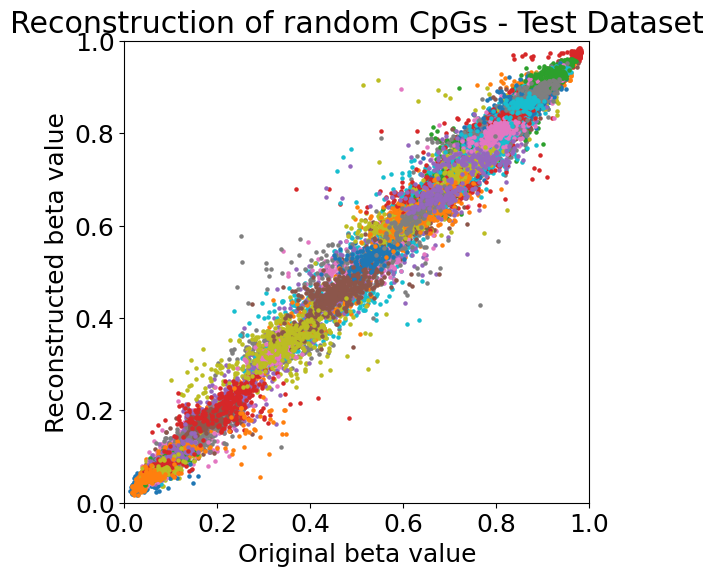

chr22 0.572 0.207


In [5]:
PATH_results = f"logs/finalModels/{CHR}"

with open(f"{PATH_results}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
latSize = dict_bestModel["latentSize"]
name = f"latSize_{latSize}"
print(name)

path = f"{PATH_results}/{name}"
model = torch.load(f"{path}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

plot_cpg_reconstruction(model, test_tensor, size=150)

mean, std = calc_r2(model, test_tensor)
print(CHR, mean, std)

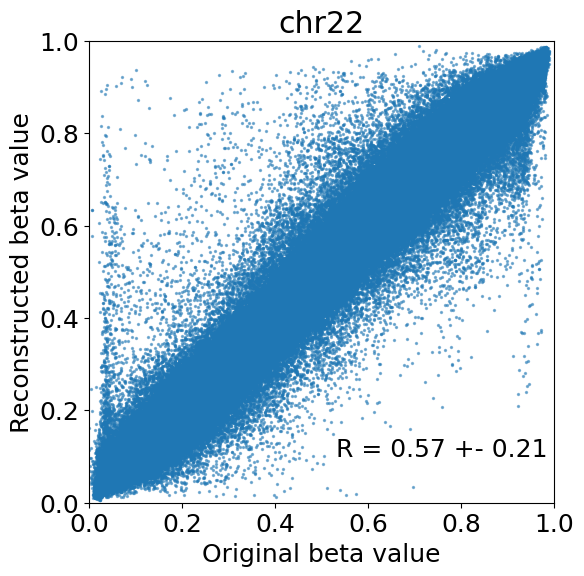

In [6]:
orig, recon, ax = plot_all_cpgs_reconstruction(model, test_tensor, title=f"{CHR}")

# ax.hlines(0,1,3)
# plt.show()

# R2 for all 

In [7]:
PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
for CHR in [f"chr{i}" for i in range(1,23)]:
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)
    
    PATH_results = f"logs/finalModels/{CHR}"
    with open(f"{PATH_results}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
    latSize = dict_bestModel["latentSize"]
    name = f"latSize_{latSize}"
    path = f"{PATH_results}/{name}"
    model = torch.load(f"{path}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
    
    mean, std = calc_r2(model, test_tensor)
    print(mean)

0.211
0.213
0.209
0.214
0.217
0.213
0.207
0.219
0.217
0.213
0.209
0.211
0.215
0.228
0.223
0.224
0.225
0.215
0.221
0.205
0.194
0.207
